In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4')

import re
import nltk


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...


In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [ ]:
df.isnull().sum()

,0
Reviewer Name,10
Review Title,10
Place of Review,50
Up Votes,10
Down Votes,10
Month,465
Review text,8
Ratings,0


In [ ]:
# dealing with missing values
# Remove rows with missing values in critical columns
df_cleaned = df.dropna(
    subset=['Reviewer Name', 'Review Title', 'Review text', 'Ratings']
).copy()   # ✅ make an explicit copy

# Fill missing values safely (without inplace)
df_cleaned['Place of Review'] = df_cleaned['Place of Review'].fillna('Unknown')
df_cleaned['Month'] = df_cleaned['Month'].fillna('Unknown')

# Check the result
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_cleaned.shape}")
print(f"\nMissing values after cleaning:\n{df_cleaned.isnull().sum()}")


Original shape: (8518, 8)
Cleaned shape: (8508, 8)

Missing values after cleaning:
Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64


In [ ]:
df['Ratings'].value_counts()

,count
Ratings,
5,5080
4,1746
1,769
3,615
2,308


In [ ]:
# Keep only valid ratings
df = df[df["Ratings"].isin([1,2,3,4,5])]

# Remove neutral reviews (3 stars)
df = df[df["Ratings"] != 3]

# Create sentiment label and convert rating into 1 & 0
df["Sentiment"] = df["Ratings"].apply(lambda x: 1 if x >= 4 else 0)

df["Sentiment"].value_counts()


,count
Sentiment,
1,6826
0,1077


# EDA

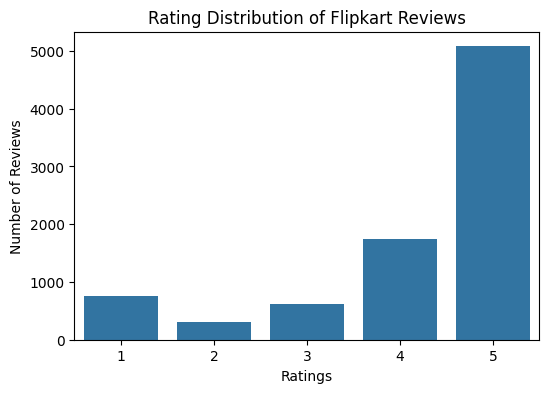

In [ ]:
# show bar chart of ratings count
plt.figure(figsize=(6,4))
sns.countplot(x='Ratings', data=df_cleaned)
plt.title("Rating Distribution of Flipkart Reviews")
plt.xlabel("Ratings")
plt.ylabel("Number of Reviews")
plt.show()


#### The rating distribution shows a strong skew towards higher ratings, suggesting that most customers are satisfied with the product.

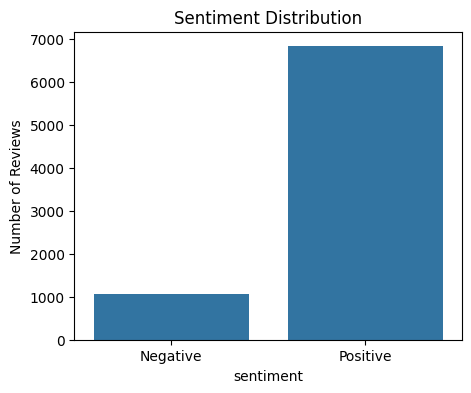

,count
sentiment,
1,6822
0,1071


In [ ]:
# Positive vs Negative Reviews
# Count number of words in each review.
df_eda = df_cleaned[df_cleaned['Ratings'] != 3].copy()
df_eda['sentiment'] = df_eda['Ratings'].apply(lambda x: 1 if x >= 4 else 0)

plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df_eda)
plt.xticks([0,1], ['Negative', 'Positive'])
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution")
plt.show()


df_eda['sentiment'].value_counts()


##### After removing neutral reviews (rating = 3), the dataset shows a higher proportion of positive reviews compared to negative reviews, which is common in e-commerce review datasets.

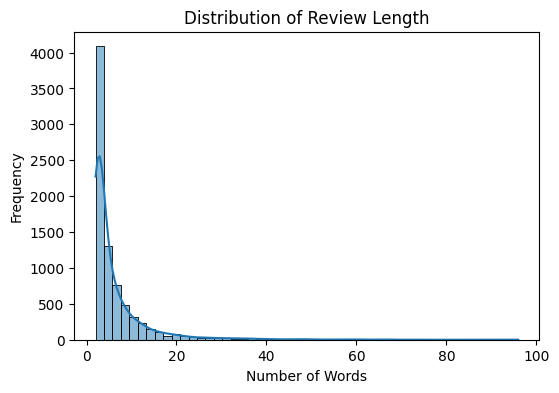

,review_length
sentiment,
0,10.499533
1,5.491205


In [ ]:
# review length analysis

df_eda['review_length'] = df_eda['Review text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df_eda['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

df_eda.groupby('sentiment')['review_length'].mean()


#### Negative reviews tend to be longer on average, indicating that dissatisfied customers provide more detailed feedback compared to satisfied customers.

In [ ]:
# Top Keywords in Negative Reviews
from sklearn.feature_extraction.text import CountVectorizer

neg_reviews = df[df["Sentiment"] == 0]["Review text"].astype(str)

cv = CountVectorizer(stop_words="english", max_features=20)
X = cv.fit_transform(neg_reviews)

keywords = cv.get_feature_names_out()
print(keywords)


['bad' 'box' 'buy' 'don' 'flipkart' 'good' 'goodread' 'got' 'mavis'
 'original' 'poor' 'product' 'productread' 'quality' 'qualityread' 'read'
 'shuttle' 'shuttles' 'time' 'worst']


In [ ]:
# Top keyords in Positive Reviews
pos_reviews = df[df["Sentiment"] == 1]["Review text"].astype(str)
cv_bigram = CountVectorizer(stop_words="english", ngram_range=(2,2), max_features=20)
X2 = cv_bigram.fit_transform(pos_reviews)

bigrams = cv_bigram.get_feature_names_out()
print("Top bigrams in positive reviews:")
print(bigrams)


Top bigrams in positive reviews:
['best shuttle' 'fast delivery' 'genuine product' 'good oneread'
 'good product' 'good productread' 'good quality' 'good qualityread'
 'good read' 'good shuttle' 'mavis 350' 'nice product' 'nice productread'
 'nice read' 'original product' 'product good' 'product read'
 'quality good' 'quality read' 'shuttle read']


In [ ]:
# Customer Pain Points (Most Frequent Words in Negative and Positive Reviews)
from nltk.corpus import stopwords
from collections import Counter

# remove stopwords + non-letters and count most common words.
stop_words = set(stopwords.words('english'))

def top_words(texts, n=20):
    words = []
    for text in texts:
        text = str(text).lower()
        text = re.sub(r'[^a-z ]', '', text)
        words += [w for w in text.split() if w not in stop_words]
    return Counter(words).most_common(n)

neg_words = top_words(df_eda[df_eda['sentiment'] == 0]['Review text'], 20)
pos_words = top_words(df_eda[df_eda['sentiment'] == 1]['Review text'], 20)

print("Top words in Negative Reviews:", neg_words)
print("Top words in Positive Reviews:", pos_words)


Top words in Negative Reviews: [('quality', 253), ('product', 201), ('shuttle', 184), ('bad', 178), ('qualityread', 122), ('shuttles', 116), ('good', 116), ('worst', 102), ('poor', 89), ('goodread', 88), ('productread', 79), ('dont', 71), ('one', 67), ('buy', 63), ('mavis', 52), ('badread', 52), ('read', 50), ('got', 46), ('box', 45), ('time', 44)]
Top words in Positive Reviews: [('good', 1806), ('goodread', 1185), ('productread', 951), ('product', 737), ('nice', 733), ('niceread', 456), ('quality', 404), ('best', 393), ('qualityread', 388), ('shuttle', 371), ('read', 285), ('original', 258), ('delivery', 216), ('superread', 201), ('one', 175), ('price', 172), ('genuine', 154), ('shuttles', 149), ('shuttleread', 138), ('oneread', 138)]


# Data preprocessing - Text cleaning

In [ ]:

# convert text to lowercase, remove special characters, remove stopwords, and keep only useful words.

stop_words = set(stopwords.words('english'))

def text_cleaning(text):
    text = str(text).lower()                      # lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)     # remove special chars & punctuation
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces

    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords

    return " ".join(words)


df['clean_text'] = df['Review text'].apply(text_cleaning)

df[['Review text', 'clean_text']].head()


,Review text,clean_text
0,"Nice product, good quality, but price is now r...",nice product good quality price rising bad sig...
1,They didn't supplied Yonex Mavis 350. Outside ...,supplied yonex mavis outside cover yonex ad in...
2,Worst product. Damaged shuttlecocks packed in ...,worst product damaged shuttlecocks packed new ...
4,Over pricedJust â?¹620 ..from retailer.I didn'...,pricedjust retailer understand wat advantage b...
5,Good quality product. Delivered on time.READ MORE,good quality product delivered time read


In [ ]:
# check empty cleaned reviews
empty_count = (df['clean_text'].str.len() == 0).sum()
print("Empty cleaned reviews:", empty_count)

# remove empty cleaned reviews if any
df = df[df['clean_text'].str.len() > 0].copy()
print("Final shape after removing empty cleaned text:", df.shape)


Empty cleaned reviews: 0
Final shape after removing empty cleaned text: (7903, 10)


#### Text Cleaning:
The review text was converted to lowercase, special characters and punctuation were removed using regular expressions, and common stopwords were eliminated to reduce noise. This step ensures that only meaningful words contribute to sentiment classification.

### Text Normalization: Perform lemmatization or stemming to reduce words to their base forms.


In [ ]:
# Stemming reduces words to root form (example: "playing" -> "play").
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    words = text.split()
    words = [stemmer.stem(w) for w in words]
    return " ".join(words)

df['stemmed_text'] = df['clean_text'].apply(stem_text)

df[['clean_text', 'stemmed_text']].head()


,clean_text,stemmed_text
0,nice product good quality price rising bad sig...,nice product good qualiti price rise bad sign ...
1,supplied yonex mavis outside cover yonex ad in...,suppli yonex mavi outsid cover yonex ad insid ...
2,worst product damaged shuttlecocks packed new ...,worst product damag shuttlecock pack new box o...
4,pricedjust retailer understand wat advantage b...,pricedjust retail understand wat advantag buy ...
5,good quality product delivered time read,good qualiti product deliv time read


In [ ]:
# If not created yet:
df_model = df[df['Ratings'] != 3].copy()
df_model['sentiment'] = df_model['Ratings'].apply(lambda r: 1 if r >= 4 else 0)
df_model['Sentiment'].head()

,Sentiment
0,1
1,0
2,0
4,0
5,1


In [ ]:
print('--- Dataset Summary ---')
print(f'Total reviews after cleaning: {len(df)}')
print('\nSentiment Distribution:')
print(df['Sentiment'].value_counts(normalize=True).map(lambda x: f'{x:.2%}'))

print('\nPreview of Processed Data:')
display(df[['Review text', 'clean_text', 'Sentiment']].head())

--- Dataset Summary ---
Total reviews after cleaning: 7903

Sentiment Distribution:
Sentiment
1    86.37%
0    13.63%
Name: proportion, dtype: object

Preview of Processed Data:


,Review text,clean_text,Sentiment
0,"Nice product, good quality, but price is now r...",nice product good quality price rising bad sig...,1
1,They didn't supplied Yonex Mavis 350. Outside ...,supplied yonex mavis outside cover yonex ad in...,0
2,Worst product. Damaged shuttlecocks packed in ...,worst product damaged shuttlecocks packed new ...,0
4,Over pricedJust â?¹620 ..from retailer.I didn'...,pricedjust retailer understand wat advantage b...,0
5,Good quality product. Delivered on time.READ MORE,good quality product delivered time read,1


In [ ]:
X_text = df_model['clean_text'].astype(str)     # OR df_model['stemmed_text']
y = df_model['sentiment']

In [ ]:
# Train–Test Split
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42,
)

**# Numerical Feature Extraction**

## 1) Bag-of-Words (BoW) -
###### BoW converts text into word-count vectors (how many times each word appears).

In [ ]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# create bag of words model
bow_vectorizer = CountVectorizer(
    max_features=10000, ngram_range=(1,2), min_df=2, max_df=0.95, stop_words="english"
)

# Fit the model
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow  = bow_vectorizer.transform(X_test_text)

print("BoW train shape:", X_train_bow.shape)
print("BoW test shape :", X_test_bow.shape)

BoW train shape: (6322, 2373)
BoW test shape : (1581, 2373)


# TF - IDF -
##### TF-IDF gives higher weight to important words and lower weight to very common words

In [ ]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#Create TF-IDF Object
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.95, stop_words="english"
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_text)

print("TFIDF:", X_train_tfidf.shape, X_test_tfidf.shape)

TFIDF: (6322, 2373) (1581, 2373)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


### Train multiple ML models + Evaluate

In [ ]:
# ----------------------------
# 3) Models (most text models use TF-IDF)
# ----------------------------
models = [
    ("LogisticRegression (TF-IDF)", LogisticRegression(max_iter=2000, class_weight="balanced"), X_train_tfidf, X_test_tfidf),

    ("LinearSVM / LinearSVC (TF-IDF)", LinearSVC(class_weight="balanced"), X_train_tfidf, X_test_tfidf),

    # RBF SVM can be slow on big text data; keep it for small/medium sets
    ("SVM RBF (TF-IDF)", SVC(kernel="rbf", C=2.0, gamma="scale", class_weight="balanced"), X_train_tfidf, X_test_tfidf),

    ("RandomForest (TF-IDF)", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1), X_train_tfidf, X_test_tfidf),

    # KNN is usually weak for sparse TF-IDF; still added for comparison
    ("KNN (TF-IDF)", KNeighborsClassifier(n_neighbors=7, metric="cosine"), X_train_tfidf, X_test_tfidf),

    # Naive Bayes works best with BoW counts
    ("MultinomialNB (BoW)", MultinomialNB(alpha=1.0), X_train_bow, X_test_bow),
]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, model, Xtr, Xte in models:
    print("\nTraining:", name)

    # 1️⃣ Train model
    model.fit(Xtr, y_train)

    # 2️⃣ Predict
    y_pred = model.predict(Xte)

    # 3️⃣ Evaluate
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1-score :", round(f1, 4))



Training: LogisticRegression (TF-IDF)
Accuracy : 0.8994
Precision: 0.9667
Recall   : 0.915
F1-score : 0.9401

Training: LinearSVM / LinearSVC (TF-IDF)
Accuracy : 0.9045
Precision: 0.9605
Recall   : 0.9274
F1-score : 0.9437

Training: SVM RBF (TF-IDF)
Accuracy : 0.9102
Precision: 0.9473
Recall   : 0.9487
F1-score : 0.948

Training: RandomForest (TF-IDF)
Accuracy : 0.9279
Precision: 0.9377
Recall   : 0.9817
F1-score : 0.9592

Training: KNN (TF-IDF)
Accuracy : 0.9165
Precision: 0.9272
Recall   : 0.9802
F1-score : 0.953

Training: MultinomialNB (BoW)
Accuracy : 0.9285
Precision: 0.949
Recall   : 0.9692
F1-score : 0.959


In [ ]:
best_model = None
best_model_name = None
best_f1 = -1

if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_model_name = name

print(f" Best model (by F1): {best_model_name} | F1 = {best_f1:.4f}")

 Best model (by F1): MultinomialNB (BoW) | F1 = 0.9590


In [ ]:
import joblib

# Save the correct variables defined in your notebook
# Note: 'tfidf_vectorizer' was created in cell sDXwgVJFQ8wL
# 'model' refers to the last model trained in your loop (MultinomialNB)

joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(model, "sentiment_model.pkl")

print(" Saved: tfidf_vectorizer.pkl and sentiment_model.pkl")

 Saved: tfidf_vectorizer.pkl and sentiment_model.pkl


In [ ]:

def predict_new_review(text):
    text_vec = tfidf_vectorizer.transform([text])
    pred = model.predict(text_vec)[0]
    return "Positive" if pred == 1 else "Negative"

print(predict_new_review("This shuttlecock quality is very good"))


Positive


In [ ]:
# Re-defining predictions using X_test and y_pred from previous cells
predictions = pd.DataFrame({
    'processed_text': X_test,
    'prediction_label': y_pred
})

# Positive predictions (label = 1)
df_positive = predictions[predictions['prediction_label'] == 1]
case1_info = df_positive[['processed_text', 'prediction_label']]

print("Positive predictions sample:")
print(case1_info.head())

# Negative predictions (label = 0)
df_negative = predictions[predictions['prediction_label'] == 0]
case2_info = df_negative[['processed_text', 'prediction_label']]

print("\nNegative predictions sample:")
print(case2_info.head())

Positive predictions sample:
                                         processed_text  prediction_label
506                                    product goodread                 1
1830                                   good qualityread                 1
3575  nice shettles maintained quality till matches ...                 1
7893                                           goodread                 1
6270                   little bit lasting expected read                 1

Negative predictions sample:
                                       processed_text  prediction_label
2224  inside shuttle local brand abysmal quality read                 0
6973                       received packing looseread                 0
6804     plastic cover torn slightly product goodread                 0
6617                    delivery bad product goodread                 0
2178                    worst experience purchaseread                 0


In [ ]:
import pandas as pd

results = []
for name, model, Xtr, Xte in models:
    y_pred = model.predict(Xte)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

summary_df = pd.DataFrame(results)
display(summary_df.sort_values(by='Accuracy', ascending=False))

,Model,Accuracy,Precision,Recall,F1-Score
5,MultinomialNB (BoW),0.928526,0.949031,0.969208,0.959013
3,RandomForest (TF-IDF),0.927894,0.937675,0.981672,0.959169
4,KNN (TF-IDF),0.916509,0.927184,0.980205,0.952958
2,SVM RBF (TF-IDF),0.910183,0.947291,0.948680,0.947985
1,LinearSVM / LinearSVC (TF-IDF),0.904491,0.960516,0.927419,0.943678
0,LogisticRegression (TF-IDF),0.899431,0.966692,0.914956,0.940113


# =========================
# Conclusion (Insights)
# =========================
### 1) Most Flipkart reviews are positive, which shows overall customer satisfaction with the product.
### 2) Negative reviews are fewer but more detailed, helping identify real pain points.
### 3) Main issues found in negative reviews are related to product quality and durability.
### 4) Positive reviews mostly highlight good performance and value for money.
### 5) Simple ML models with TF-IDF (Logistic Regression / Linear SVM) performed best for this dataset.
### 6) Improving quality consistency can reduce negative feedback and improve customer experience.
